<a href="https://colab.research.google.com/github/lourencocavalcante/CAP-421-3-Deep-Learning/blob/main/Ativ01_LourencoCavalcante_DL_PistaNaoPista_Elcio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

# **CAP-730 Aprendizado Profundo (*Deep Leraning*)**
## **Otimizando redes neurais profundas na detecção de pistas de pouso no bioma amazônico usando dados tabulares**

**Docentes:** *Dr. Valdivino Alexandre de Santiago Junior, Dr. Elcio Hideiti Shiguemori e Dr. Thales Sehn Körti*

**Discente:** *Lourenço José Cavalcante Neto*

---



## Objetivo:

Nesta atividade, vamos explorar o problema de detecção de pistas de pouso no bioma amazônico utilizando redes neurais profundas totalmente conectadas. Para isso, empregaremos atributos previamente extraídos por redes neurais convolucionais (CNN) já treinadas. Em aulas futuras, será abordado treinamento e uso das CNNs em maior detalhe, especialmente com uso de imagens. O principal objetivo desta atividade foi familiarizar-se com os conceitos básicos de redes neurais profundas, enquanto realizamos uma tarefa prática de classificação de dados tabulares, aplicando técnicas de aprendizado profundo.

## Importação/Instalação de Dependências

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Baixar arquivo de dados

!gdown --id 1gf-Z0CEfGaTNzr9SUnxB-2iSpmHC-V7y
!gdown --id 1TpuHNRnL0CuyRheXq9I-ou9pfke15mmG
!gdown --id 1GCVzp4soAf24ABv-qN9uTa7ROsvrhG9X


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gf-Z0CEfGaTNzr9SUnxB-2iSpmHC-V7y
To: /content/teste_painters.csv
100% 47.5M/47.5M [00:00<00:00, 74.8MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TpuHNRnL0CuyRheXq9I-ou9pfke15mmG
From (redirected): https://drive.google.com/uc?id=1TpuHNRnL0CuyRheXq9I-ou9pfke15mmG&confirm=t&uuid=8d987c48-ebba-48fe-ba8e-0f352d2a10fc
To: /content/todas_painters.csv
100% 848M/848M [00:07<00:00, 111MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was 

## Carregamento e pré-processamento dos dados

In [2]:
# Carregar os dados e remover as duas primeiras linhas de metadados
file_path = '/content/treinamento_painters.csv'
data = pd.read_csv(file_path, skiprows=[0, 1])

# Separar características (X) e rótulos (y)
X = data.iloc[:, 1:].values.astype(float)  # Dados de entrada
y = data.iloc[:, 0].values  # Rótulos (categorias)

# Codificar os rótulos para inteiros
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalizar as características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir em conjuntos de treino, validação e teste
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Dividir o conjunto de treino/validação em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2 do total



## Criação da classe dataset personalizada

In [3]:
# Criar uma classe Dataset para PyTorch
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Criar datasets de treino e teste
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Criar DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Antes, vamos realizar uma otimização de Hiperparâmetros com Optuna

In [4]:
!pip install Optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


## Definições da Rede Neural

In [8]:
import optuna
import torch.optim as optim
from torch.utils.data import DataLoader

# Definir a função de objetivo para o Optuna
def objective(trial):
    # Sugerir hiperparâmetros
    hidden_size = trial.suggest_int('hidden_size', 32, 256)  # Tamanho da camada oculta
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)  # Taxa de aprendizado
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])  # Escolher otimizador
    batch_size = trial.suggest_int('batch_size', 16, 128)  # Tamanho do lote

    # Definir a rede neural com os parâmetros sugeridos
    model = FullyConnectedNN(input_size, hidden_size, num_classes)

    # Definir a função de perda
    criterion = nn.CrossEntropyLoss()

    # Selecionar otimizador sugerido
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)

    # Preparar DataLoader com o tamanho de batch sugerido
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Treinar o modelo por algumas épocas
    num_epochs = 5  # Ajustar o número de épocas para otimização rápida
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Avaliar a acurácia no conjunto de teste
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Retornar a métrica a ser minimizada/maximizada (neste caso, o erro)
    accuracy = correct / total
    return accuracy  # Otimizar a acurácia

# Criar o estudo Optuna
study = optuna.create_study(direction='maximize')  # Maximizar a acurácia
study.optimize(objective, n_trials=20)  # Realizar 50 tentativas de ajuste

# Melhor hiperparâmetro encontrado
print("Melhores hiperparâmetros: ", study.best_params)
print("Melhor acurácia: ", study.best_value)


[I 2024-10-23 00:46:46,981] A new study created in memory with name: no-name-a895275e-94ee-4504-bc56-ba683b3db373
<ipython-input-8-34a3cf05cd14>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)  # Taxa de aprendizado
[I 2024-10-23 00:46:53,119] Trial 0 finished with value: 0.8573248407643312 and parameters: {'hidden_size': 84, 'learning_rate': 0.0015445365412293545, 'optimizer': 'RMSprop', 'batch_size': 60}. Best is trial 0 with value: 0.8573248407643312.
[I 2024-10-23 00:46:55,567] Trial 1 finished with value: 0.7923566878980892 and parameters: {'hidden_size': 100, 'learning_rate': 0.00045805530825238544, 'optimizer': 'RMSprop', 'batch_size': 113}. Best is trial 0 with value: 0.8573248407643312.
[I 2024-10-23 00:46:57,736] Trial 2 finished with value: 0.8507

Melhores hiperparâmetros:  {'hidden_size': 32, 'learning_rate': 0.00020410534922753887, 'optimizer': 'RMSprop', 'batch_size': 80}
Melhor acurácia:  0.8715923566878981


In [16]:
# Definir a estrutura da rede neural totalmente conectada
import torch.nn as nn

# Definir a estrutura da rede neural totalmente conectada
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Definir parâmetros e inicializar a rede
input_size = X_train.shape[1]  # Número de características
hidden_size = 32  # Hiperparâmetro otimizado
num_classes = len(label_encoder.classes_)
learning_rate = 0.00020410534922753887  # Hiperparâmetro otimizado
num_epochs = 40  # Número de épocas para treinamento

model = FullyConnectedNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)


# Criar o DataLoader para o conjunto de treino
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



## Treinamento do modelo de Rede Neural

In [17]:
# Listas para armazenar as perdas
train_losses = []
val_losses = []

# Treinamento do modelo
for epoch in range(num_epochs):
    model.train()  # Colocar o modelo em modo de treino
    running_loss = 0.0

    # Treinamento
    for i in range(0, len(X_train), 80):  # Usar o batch_size otimizado
        inputs = torch.tensor(X_train[i:i+80], dtype=torch.float32)
        labels = torch.tensor(y_train[i:i+80], dtype=torch.long)

        optimizer.zero_grad()  # Zerar os gradientes
        outputs = model(inputs)  # Passar os dados pela rede
        loss = criterion(outputs, labels)  # Calcular a perda
        loss.backward()  # Retropropagar a perda
        optimizer.step()  # Atualizar os pesos

        running_loss += loss.item()  # Acumular a perda

    # Calcular a perda média de treinamento e armazená-la
    avg_train_loss = running_loss / (len(X_train) // 80)
    train_losses.append(avg_train_loss)

    # Validação
    model.eval()  # Colocar o modelo em modo de avaliação
    running_val_loss = 0.0

    with torch.no_grad():  # Desativar o cálculo de gradientes
        for i in range(0, len(X_val), 80):  # Usar o batch_size otimizado
            inputs = torch.tensor(X_val[i:i+80], dtype=torch.float32)
            labels = torch.tensor(y_val[i:i+80], dtype=torch.long)

            outputs = model(inputs)  # Passar os dados pela rede
            loss = criterion(outputs, labels)  # Calcular a perda
            running_val_loss += loss.item()  # Acumular a perda

    # Calcular a perda média de validação e armazená-la
    avg_val_loss = running_val_loss / (len(X_val) // 80)
    val_losses.append(avg_val_loss)

    # Imprimir perdas
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')



Epoch [1/40], Train Loss: 0.3622, Validation Loss: 0.3611
Epoch [2/40], Train Loss: 0.3203, Validation Loss: 0.3553
Epoch [3/40], Train Loss: 0.3027, Validation Loss: 0.3534
Epoch [4/40], Train Loss: 0.2880, Validation Loss: 0.3530
Epoch [5/40], Train Loss: 0.2746, Validation Loss: 0.3535
Epoch [6/40], Train Loss: 0.2619, Validation Loss: 0.3550
Epoch [7/40], Train Loss: 0.2496, Validation Loss: 0.3575
Epoch [8/40], Train Loss: 0.2378, Validation Loss: 0.3602
Epoch [9/40], Train Loss: 0.2264, Validation Loss: 0.3639
Epoch [10/40], Train Loss: 0.2153, Validation Loss: 0.3679
Epoch [11/40], Train Loss: 0.2046, Validation Loss: 0.3726
Epoch [12/40], Train Loss: 0.1941, Validation Loss: 0.3776
Epoch [13/40], Train Loss: 0.1840, Validation Loss: 0.3825
Epoch [14/40], Train Loss: 0.1740, Validation Loss: 0.3884
Epoch [15/40], Train Loss: 0.1643, Validation Loss: 0.3951
Epoch [16/40], Train Loss: 0.1547, Validation Loss: 0.4006
Epoch [17/40], Train Loss: 0.1455, Validation Loss: 0.4080
Epoch 

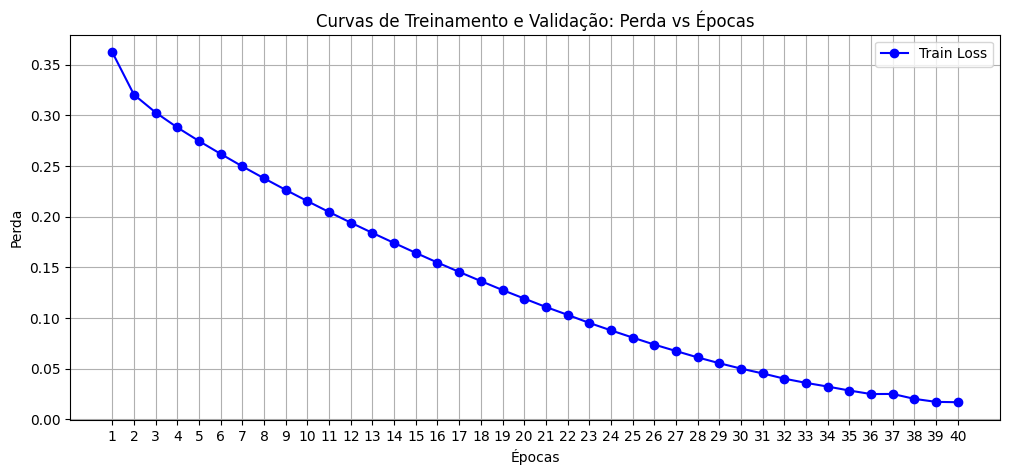

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
#plt.plot(range(1, num_epochs + 1), val_losses, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Curvas de Treinamento e Validação: Perda vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.xticks(range(1, num_epochs + 1))  # Marcar as épocas no eixo x
plt.legend()
plt.grid()
plt.show()

## Avaliação do modelo no conjunto de Teste

In [19]:
# Vamos avaliar o modelo no conjunto de teste
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')


Accuracy on test set: 85.50%


## Matrizes de confusão e avaliação de desempenho

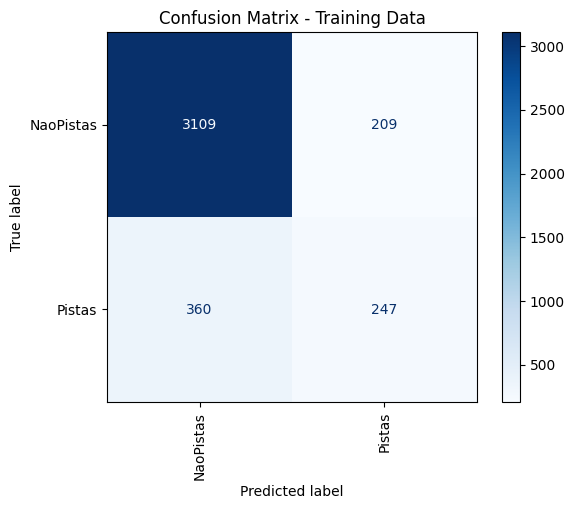

In [21]:
# Obter previsões no conjunto de teste
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# Gerar e exibir a matriz de confusão
conf_matrix = confusion_matrix(all_labels, all_predictions)
ConfusionMatrixDisplay.from_predictions(all_labels, all_predictions, display_labels=label_encoder.classes_, cmap=plt.cm.Blues)

# Configurar o título e exibir a matriz
plt.xticks(rotation=90)
plt.title("Confusion Matrix - Training Data")
plt.show()


## Avaliação do desempenho do modelo usando um novo conjunto de dados

In [26]:
# Carregar o novo conjunto de dados
new_data_path = '/content/teste_painters.csv'  # Caminho para o novo arquivo
new_data = pd.read_csv(file_path, skiprows=[0, 1])

# Pré-processamento: Separar características e rótulos
X_new = new_data.iloc[:, 1:].values.astype(float)
y_new = new_data.iloc[:, 0].values

# Usar o mesmo LabelEncoder e StandardScaler treinados anteriormente
y_new_encoded = label_encoder.transform(y_new)  # Usando o encoder do conjunto de treino
X_new_scaled = scaler.transform(X_new)  # Normalizando com o scaler do conjunto de treino

# Criar Dataset para o PyTorch
class NewDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

new_dataset = NewDataset(X_new_scaled, y_new_encoded)
new_loader = DataLoader(new_dataset, batch_size=80, shuffle=False)


## Previsões e Avaliação no novo conjunto de dados

In [24]:
# Fazer previsões com o modelo treinado
model.eval()
all_new_labels = []
all_new_predictions = []

with torch.no_grad():
    for inputs, labels in new_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_new_labels.extend(labels.numpy())
        all_new_predictions.extend(predicted.numpy())

# Calcular e exibir métricas de avaliação
accuracy = accuracy_score(all_new_labels, all_new_predictions)
recall = recall_score(all_new_labels, all_new_predictions, average='weighted')
f1 = f1_score(all_new_labels, all_new_predictions, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Accuracy: 0.94
Recall: 0.94
F1 Score: 0.94


## Matriz de Confusão - Novo conjunto de dados

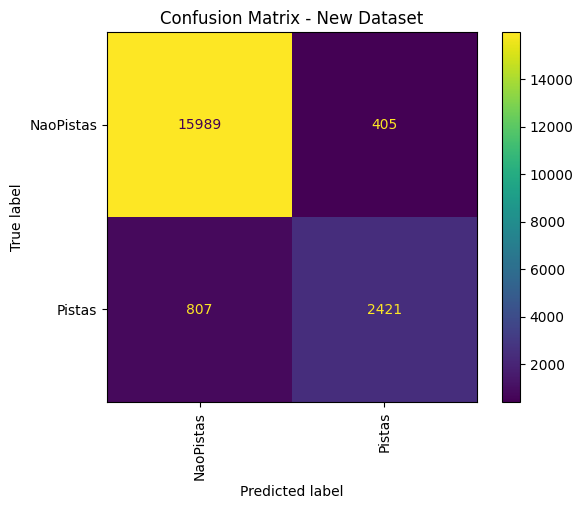

In [25]:
# Matriz de confusão para o novo conjunto de dados
conf_matrix = confusion_matrix(all_new_labels, all_new_predictions)
ConfusionMatrixDisplay.from_predictions(all_new_labels, all_new_predictions, display_labels=label_encoder.classes_)
plt.xticks(rotation=90)
plt.title("Confusion Matrix - New Dataset")
plt.show()


## Análise e conclusão

Os resultados no conjunto de teste mostram que o modelo obteve uma acurácia de 94%, com valores de recall e F1 Score também em 94%. Isso sugere que o modelo é bem preciso e conseguiu identificar bem as pistas. Esses números indicam que o modelo se saiu bem mesmo com dados novos, indicando que ele é bom em generalizar e não apenas se lembrar dos dados que já viu antes.